In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore')

import time
from glob import glob
from tqdm import tqdm

import tensorflow as tf
import tensorflow.keras as keras
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras import backend as K
from keras.utils import plot_model

from keras.layers import Activation, Dense, LSTM, GRU, Bidirectional, AveragePooling1D, GlobalAveragePooling1D, Dropout, Flatten, BatchNormalization, TimeDistributed, Input, Reshape, RepeatVector, Concatenate, GlobalMaxPooling1D 
from keras.layers.convolutional import Conv1D, MaxPooling1D, AveragePooling1D


#GPU 자원이 부족
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [ ]:
raw_data = pd.read_csv('C:/Users/sjkan/Desktop/연세/YBIGTA/22 여름방학/신입기수프로젝트/rawdata.csv')
raw_data_ = raw_data[:-6912]
raw_data__= raw_data[-6912:]

In [ ]:
raw_data_.isnull().sum()

In [ ]:
raw_data_[raw_data_['청담대교_수위'].isnull() == True]

In [ ]:
raw_data__.isnull().sum()

날짜            0
현재수위         36
유입량          36
저수량          36
공용량          36
방류량          36
강화대교_조위       4
청담대교_유량    1216
잠수교_유량     6912
한강대교_유량       0
행주대교_유량       0
대곡교_강수량       0
진관교_강수량       0
송정동_강수량       0
청담대교_수위       0
잠수교_수위        0
한강대교_수위       0
행주대교_수위       0
dtype: int64

In [ ]:
pd.set_option('display.max_rows', None) 
raw_data__[raw_data__['방류량'].isnull() == True]

In [ ]:
pd.set_option('display.max_rows', 10) 

In [ ]:
raw_data = pd.read_csv('C:/Users/sjkan/Desktop/연세/YBIGTA/22 여름방학/신입기수프로젝트/rawdata.csv')
newdata = pd.read_csv('C:/Users/sjkan/Desktop/newdata.csv', encoding = 'cp949')
newdata = newdata[:-1]

In [ ]:
raw_data = raw_data[:-6912]
raw_data

In [ ]:
newdata = newdata[:-6912]
newdata

In [ ]:
# 날짜를 index로 바꾸고 dtype을 datetime으로 바꾸기
newdata.set_index(keys = ['날짜'], inplace = True)
raw_data.set_index(keys = ['날짜'], inplace = True)
newdata.index = pd.to_datetime(raw_data.index, format = '%Y-%m-%d %H:%M')
raw_data.index = pd.to_datetime(raw_data.index, format = '%Y-%m-%d %H:%M')

In [ ]:
xdata = newdata[['공용량','방류량','강화대교_조위']]
xdata

In [ ]:
# 정규화
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

input_x_regular = xdata.copy()

for i in range(len(xdata.columns)):
    scaler = MinMaxScaler()                       #StandardScaler() , MinMaxScaler() , RobustScaler()
    a=np.array(input_x_regular.iloc[:,i])
    tmp_x = scaler.fit_transform(a.reshape(-1,1))
    input_x_regular.iloc[:,i] = tmp_x

In [ ]:
input_x_regular = input_x_regular.reset_index()
input_x_regular = input_x_regular[['공용량','방류량','강화대교_조위']]
input_x_regular = pd.DataFrame(input_x_regular)
input_x_regular

,공용량,방류량,강화대교_조위
0,0.094187,0.058462,0.191781
1,0.095096,0.058447,0.199253
2,0.095758,0.057689,0.209215
3,0.095758,0.058462,0.219178
4,0.095758,0.058451,0.232877
...,...,...,...
269419,0.098652,0.042224,0.637609
269420,0.098652,0.042234,0.620174
269421,0.098652,0.042223,0.601494
269422,0.097122,0.042229,0.585305


# 원하는 칼럼명 입력하기

In [ ]:
#ydata = raw_data[['현재수위','유입량','저수량','공용량','방류량','강화대교_조위','청담대교_유량','잠수교_유량','한강대교_유량']]
ydata = raw_data[['행주대교_유량','청담대교_수위','잠수교_수위','한강대교_수위','행주대교_수위']]

# 원하는 칼럼명 입력하기

In [ ]:
ydata = ydata.reset_index()
ydata = ydata[['행주대교_유량','청담대교_수위','잠수교_수위','한강대교_수위','행주대교_수위']]
ydata = pd.DataFrame(ydata)
ydata

,행주대교_유량,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위
0,540.18,310.7,300.2,290.0,275.3
1,540.18,314.7,300.2,290.0,275.3
2,540.18,313.7,301.2,290.0,275.3
3,552.17,311.7,301.2,290.0,276.3
4,564.29,311.7,301.2,291.0,277.3
...,...,...,...,...,...
269419,493.58,281.7,281.2,278.0,271.3
269420,505.03,279.7,279.2,278.0,272.3
269421,505.03,278.7,277.2,277.0,272.3
269422,493.58,277.7,276.2,276.0,271.3


In [ ]:
input_regular = pd.concat([input_x_regular, ydata], axis = 1)
input_regular

,공용량,방류량,강화대교_조위,행주대교_유량,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위
0,0.094187,0.058462,0.191781,540.18,310.7,300.2,290.0,275.3
1,0.095096,0.058447,0.199253,540.18,314.7,300.2,290.0,275.3
2,0.095758,0.057689,0.209215,540.18,313.7,301.2,290.0,275.3
3,0.095758,0.058462,0.219178,552.17,311.7,301.2,290.0,276.3
4,0.095758,0.058451,0.232877,564.29,311.7,301.2,291.0,277.3
...,...,...,...,...,...,...,...,...
269419,0.098652,0.042224,0.637609,493.58,281.7,281.2,278.0,271.3
269420,0.098652,0.042234,0.620174,505.03,279.7,279.2,278.0,272.3
269421,0.098652,0.042223,0.601494,505.03,278.7,277.2,277.0,272.3
269422,0.097122,0.042229,0.585305,493.58,277.7,276.2,276.0,271.3


# 원하는 칼럼명 입력하기

In [ ]:
input_x_ = input_regular[['공용량','방류량','강화대교_조위']]
input_y_ = input_regular.drop(input_x_.columns, axis = 1)

In [ ]:
input_x_

,공용량,방류량,강화대교_조위
0,0.094187,0.058462,0.191781
1,0.095096,0.058447,0.199253
2,0.095758,0.057689,0.209215
3,0.095758,0.058462,0.219178
4,0.095758,0.058451,0.232877
...,...,...,...
269419,0.098652,0.042224,0.637609
269420,0.098652,0.042234,0.620174
269421,0.098652,0.042223,0.601494
269422,0.097122,0.042229,0.585305


In [ ]:
input_y_.isnull().sum()

행주대교_유량    59
청담대교_수위    59
잠수교_수위     59
한강대교_수위    59
행주대교_수위    59
dtype: int64

# 원하는 칼럼명 입력하기

In [ ]:
nanIndex = input_y_[input_y_['행주대교_유량'].isnull() == True].index

In [ ]:
nanIndex

Int64Index([140613, 140614, 140615, 140616, 140617, 140618, 140619, 140620,
            140621, 140622, 140623, 140624, 140625, 140626, 140627, 140628,
            140629, 140630, 140631, 140632, 140633, 140634, 140635, 140636,
            140637, 140638, 140639, 140640, 140641, 140642, 140643, 140644,
            140645, 140646, 140647, 140648, 140649, 140650, 140651, 140652,
            140653, 140654, 140655, 140656, 140657, 140658, 140659, 140660,
            140661, 140662, 140663, 140664, 140665, 140666, 140667, 140668,
            140669, 140670, 236080],
           dtype='int64')

In [ ]:
from tqdm import tqdm

xdata = []
ydata = []
xdata_idx = []
ydata_idx = [-5,-4,-3,-2,-1]
for i in range(len(input_regular.columns)-5):
    xdata_idx.append(i)

w =  6 #window size

idx = []
for i in range(12):
  idx.append(i*26496)

for i in tqdm(range(11)):
    if i != 10:
        tmp = input_regular[idx[i]:idx[i+1]]
    else:
        tmp = input_regular[idx[i]:]

    for j in range(len(tmp)-w):
        xdata.append(np.array(tmp.iloc[j:j + w, xdata_idx]).astype(float))

    for j in range(w,len(tmp)):
        ydata.append(np.array(tmp.iloc[j, ydata_idx]).astype(float))

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:48<00:00,  4.40s/it]


In [ ]:
print(np.array(xdata).shape)
print(np.array(ydata).shape)

(269358, 6, 3)
(269358, 5)


In [ ]:
# 나중에 학습된 모델에 이거 넣어서 predict해서 결측치 채우기
x_real_predict = []
y_real_predict = []

for i in range(len(nanIndex)):
    k = nanIndex[-(i+1)]
    
    x_real_predict.insert(0,(xdata[k - w * (k // 26496 + 1)]))
    y_real_predict.insert(0,(ydata[k - w * (k // 26496 + 1)]))
    
    xdata.pop(k - w * (k // 26496 + 1))
    ydata.pop(k - w * (k // 26496 + 1))

In [ ]:
print(np.array(x_real_predict).shape)
print(np.array(y_real_predict).shape)

(59, 6, 3)
(59, 5)


In [ ]:
print(np.array(xdata).shape)
print(np.array(ydata).shape)

(269299, 6, 3)
(269299, 5)


In [ ]:
pd.DataFrame(ydata).isnull().sum()

0    0
1    0
2    0
3    0
4    0
dtype: int64

In [ ]:
xtrain = np.array(xdata[:-50000])
ytrain = np.array(ydata[:-50000])

xtest = np.array(xdata[-50000:])
ytest = np.array(ydata[-50000:])

In [ ]:
print(xtrain.shape)
print(ytrain.shape)
print(xtest.shape)
print(ytest.shape)

(219299, 6, 3)
(219299, 5)
(50000, 6, 3)
(50000, 5)


## 모델 생성

In [ ]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

if 'model_enc_dec_cnn' in locals(): 
    del model_enc_dec_cnn 
if 'history' in locals():
    del history

optimizer = tf.keras.optimizers.Adam(lr=0.01) #기본값 0.001

model_enc_dec_cnn = Sequential()
model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=2, padding = 'causal', activation='relu', input_shape=(w, xtrain.shape[2])))
model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=2, padding = 'causal', activation='relu'))
model_enc_dec_cnn.add(MaxPooling1D(pool_size=2))
model_enc_dec_cnn.add(Flatten())

model_enc_dec_cnn.add(RepeatVector(1))
model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
model_enc_dec_cnn.add(LSTM(200, activation='relu'))

model_enc_dec_cnn.add(Dense(100, activation='relu'))
model_enc_dec_cnn.add(Dense(5))

model_enc_dec_cnn.compile(loss=root_mean_squared_error, optimizer=optimizer, metrics =["accuracy"])

model_enc_dec_cnn.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 6, 64)             448       
                                                                 
 conv1d_7 (Conv1D)           (None, 6, 64)             8256      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 3, 64)            0         
 1D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 192)               0         
                                                                 
 repeat_vector_4 (RepeatVect  (None, 1, 192)           0         
 or)                                                             
                                                                 
 lstm_30 (LSTM)              (None, 1, 200)           

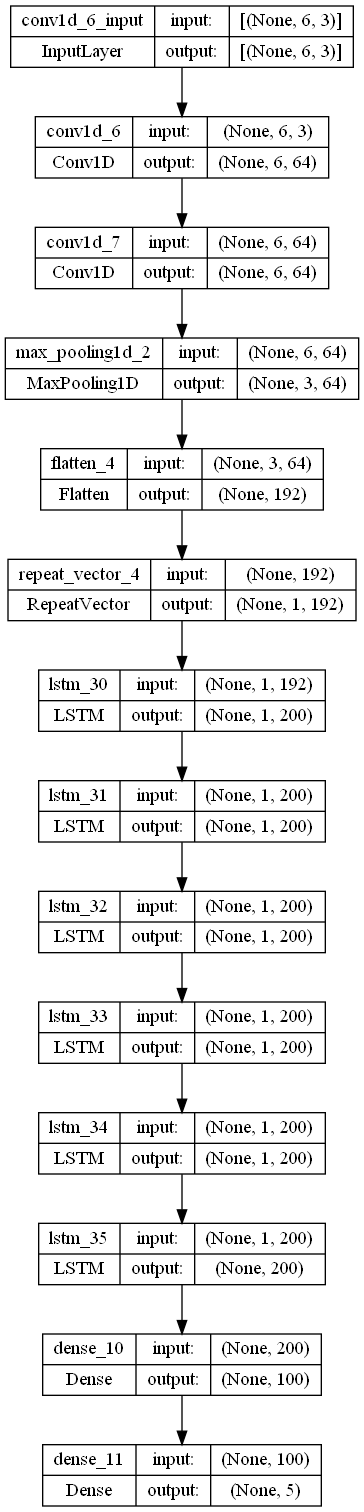

In [ ]:
plot_model(model=model_enc_dec_cnn, show_shapes=True)

In [ ]:
epochs = 100
batch_size = xtrain.shape[0] // 1000
validation = 0.2

checkpoint_callback = ModelCheckpoint(filepath='best_model.h5', save_weights_only=False, monitor='val_loss',
                                         mode='min', save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', min_delta=0.005, patience=10, mode='min')
rlrop_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, mode='min', patience=3, min_lr=0.001)

In [ ]:
## 학습

history = model_enc_dec_cnn.fit(xtrain, ytrain, verbose=1, epochs=epochs, batch_size=batch_size, validation_split=validation,callbacks=[early_stopping_callback, checkpoint_callback, rlrop_callback])

Epoch 1/100
802/802 [==============================] - 50s 56ms/step - loss: 259.0605 - accuracy: 0.9832 - val_loss: 145.2786 - val_accuracy: 0.9419 - lr: 0.0100
Epoch 2/100
802/802 [==============================] - 47s 59ms/step - loss: 165.8669 - accuracy: 0.9844 - val_loss: 141.6970 - val_accuracy: 0.9419 - lr: 0.0100
Epoch 3/100
802/802 [==============================] - 45s 56ms/step - loss: 156.8887 - accuracy: 0.9844 - val_loss: 104.5120 - val_accuracy: 0.9419 - lr: 0.0100
Epoch 4/100
802/802 [==============================] - 44s 55ms/step - loss: 150.0243 - accuracy: 0.9844 - val_loss: 119.0609 - val_accuracy: 0.9419 - lr: 0.0100
Epoch 5/100
802/802 [==============================] - 44s 55ms/step - loss: 144.7670 - accuracy: 0.9844 - val_loss: 99.3350 - val_accuracy: 0.9419 - lr: 0.0100
Epoch 6/100
802/802 [==============================] - 46s 57ms/step - loss: 143.9801 - accuracy: 0.9844 - val_loss: 98.4555 - val_accuracy: 0.9419 - lr: 0.0100
Epoch 7/100
802/802 [=========

In [ ]:
## 평가

keras_model_best = keras.models.load_model('best_model.h5', custom_objects={'root_mean_squared_error': root_mean_squared_error})

yhat = keras_model_best.predict(xtest, verbose=1)

yhat

keras_model_best.evaluate(xtest,ytest)

1563/1563 [==============================] - 7s 4ms/step - loss: 130.6352 - accuracy: 0.9798


[130.6351776123047, 0.9797599911689758]

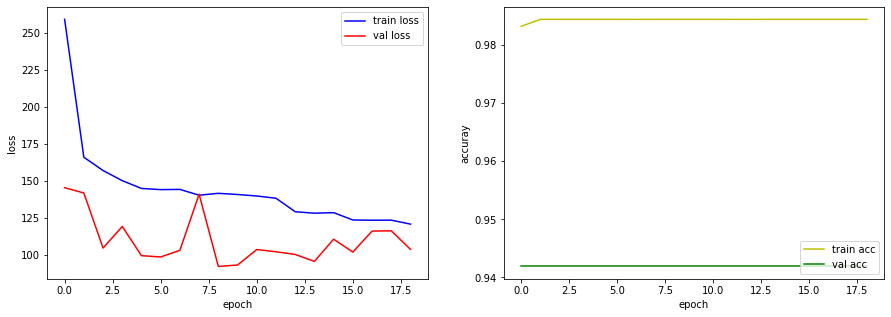

In [ ]:
## 학습 과정 시각화

fig, loss_ax = plt.subplots(1, 2)
fig.set_size_inches((15,5))

loss_ax[0].plot(history.history['loss'], 'b', label='train loss')
loss_ax[0].plot(history.history['val_loss'], 'r', label='val loss')

loss_ax[1].plot(history.history['accuracy'], 'y', label='train acc')
loss_ax[1].plot(history.history['val_accuracy'], 'g', label='val acc')

loss_ax[0].set_xlabel('epoch')
loss_ax[0].set_ylabel('loss')
loss_ax[1].set_xlabel('epoch')
loss_ax[1].set_ylabel('accuray')

loss_ax[0].legend(loc='upper right')
loss_ax[1].legend(loc='lower right')

plt.show()

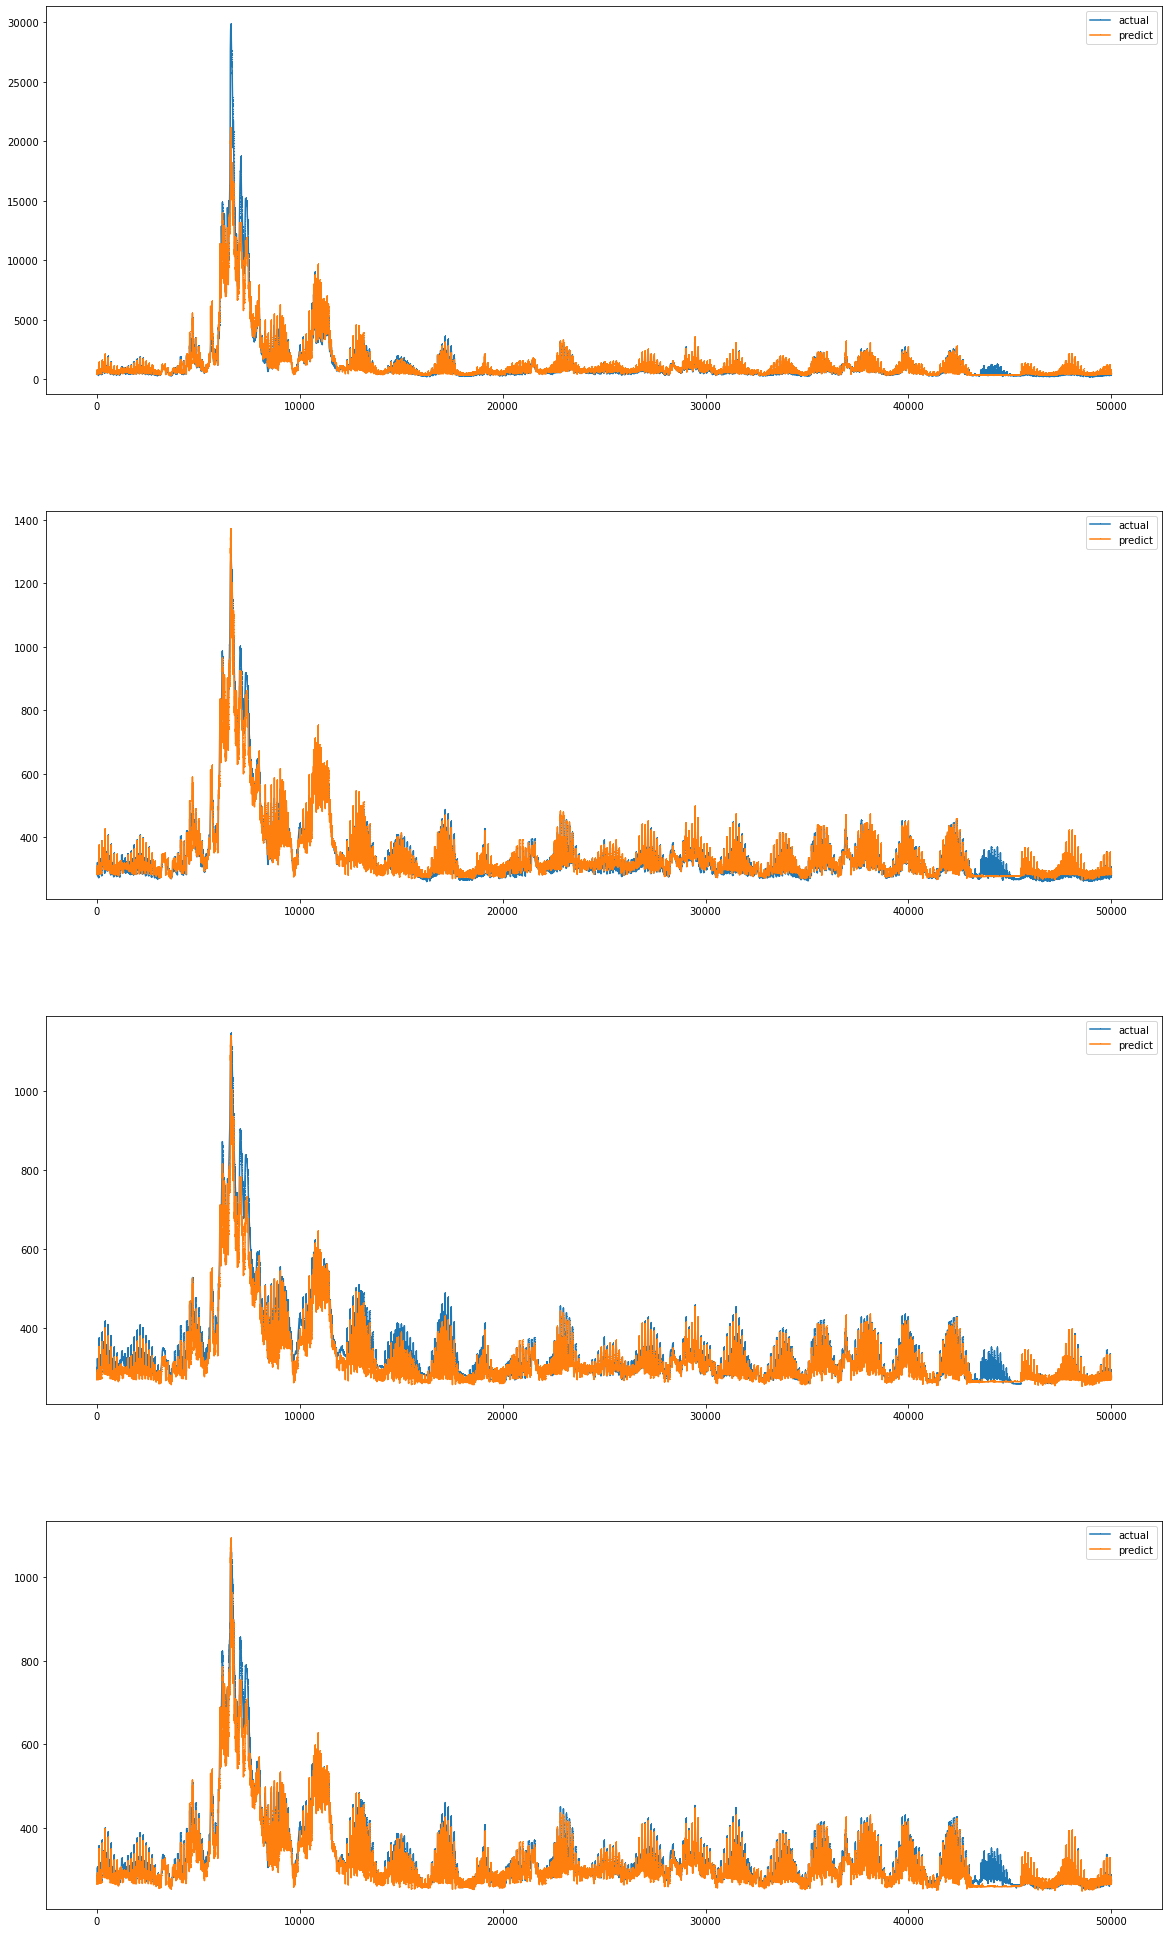

In [ ]:
## 결과 시각화
tl_predict = np.array(yhat)

f, axes = plt.subplots(4, 1)
f.set_size_inches((20, 35))
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

for i in range(4):
    axes[i].plot(ytest.T[i], marker = ",", label = "actual")
    axes[i].plot(tl_predict.T[i], marker = ",", label="predict")
    axes[i].legend(prop={'size':10})  

plt.show()

In [ ]:
## 점수 확인
float(root_mean_squared_error(ytest, tl_predict))

326.8005348785225

## 파일 저장
마지막 6912개는 없는 데이터임

# 원하는 칼럼명 입력하기

In [ ]:
raw_data2 = pd.read_csv('C:/Users/sjkan/Desktop/연세/YBIGTA/22 여름방학/신입기수프로젝트/rawdata.csv')
raw_data2 = raw_data2[:-6912]
predict_dataset = raw_data2[['행주대교_유량','청담대교_수위','잠수교_수위','한강대교_수위','행주대교_수위']]

In [ ]:
predict_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269424 entries, 0 to 269423
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   행주대교_유량  269365 non-null  float64
 1   청담대교_수위  269365 non-null  float64
 2   잠수교_수위   269365 non-null  float64
 3   한강대교_수위  269365 non-null  float64
 4   행주대교_수위  269365 non-null  float64
dtypes: float64(5)
memory usage: 10.3 MB


In [ ]:
predict_dataset.isnull().sum()

행주대교_유량    59
청담대교_수위    59
잠수교_수위     59
한강대교_수위    59
행주대교_수위    59
dtype: int64

In [ ]:
predict_dataset.iloc[nanIndex[2]]

행주대교_유량   NaN
청담대교_수위   NaN
잠수교_수위    NaN
한강대교_수위   NaN
행주대교_수위   NaN
Name: 140615, dtype: float64

In [ ]:
y_real_predict

[array([nan, nan, nan, nan, nan]),
 array([nan, nan, nan, nan, nan]),
 array([nan, nan, nan, nan, nan]),
 array([nan, nan, nan, nan, nan]),
 array([nan, nan, nan, nan, nan]),
 array([nan, nan, nan, nan, nan]),
 array([nan, nan, nan, nan, nan]),
 array([nan, nan, nan, nan, nan]),
 array([nan, nan, nan, nan, nan]),
 array([nan, nan, nan, nan, nan]),
 array([nan, nan, nan, nan, nan]),
 array([nan, nan, nan, nan, nan]),
 array([nan, nan, nan, nan, nan]),
 array([nan, nan, nan, nan, nan]),
 array([nan, nan, nan, nan, nan]),
 array([nan, nan, nan, nan, nan]),
 array([nan, nan, nan, nan, nan]),
 array([nan, nan, nan, nan, nan]),
 array([nan, nan, nan, nan, nan]),
 array([nan, nan, nan, nan, nan]),
 array([nan, nan, nan, nan, nan]),
 array([nan, nan, nan, nan, nan]),
 array([nan, nan, nan, nan, nan]),
 array([nan, nan, nan, nan, nan]),
 array([nan, nan, nan, nan, nan]),
 array([nan, nan, nan, nan, nan]),
 array([nan, nan, nan, nan, nan]),
 array([nan, nan, nan, nan, nan]),
 array([nan, nan, na

In [ ]:
test_input = np.array(x_real_predict)
y_real_hat = keras_model_best.predict(test_input, verbose=1)

2/2 [==============================] - 0s 5ms/step


In [ ]:
y_real_hat

array([[2222.046  ,  415.7905 ,  389.12875,  386.2179 ,  362.82883],
       [2275.9143 ,  419.236  ,  392.07288,  389.02228,  364.79153],
       [2289.3076 ,  420.03366,  392.7472 ,  389.66132,  365.2191 ],
       [2207.4531 ,  414.52356,  388.0048 ,  385.12878,  361.95502],
       [2120.5923 ,  408.51843,  382.81818,  380.16293,  358.3292 ],
       [2072.5051 ,  404.2617 ,  379.0342 ,  376.49295,  355.36557],
       [2003.8339 ,  396.12982,  371.62103,  369.22403,  349.02692],
       [1914.0614 ,  387.70905,  364.09857,  361.90512,  343.0098 ],
       [1809.6202 ,  380.46405,  357.84656,  355.91116,  338.62787],
       [1672.4133 ,  372.68872,  350.75705,  348.78445,  332.83527],
       [1612.2224 ,  370.15228,  348.42706,  346.40063,  330.96335],
       [1551.2351 ,  368.3343 ,  346.77722,  344.68683,  329.76086],
       [1473.9641 ,  364.21237,  342.9692 ,  340.81888,  326.5583 ],
       [1371.6799 ,  358.71475,  337.88812,  335.66083,  322.28113],
       [1314.4507 ,  355.63748,  3

In [ ]:
predict_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269424 entries, 0 to 269423
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   행주대교_유량  269365 non-null  float64
 1   청담대교_수위  269365 non-null  float64
 2   잠수교_수위   269365 non-null  float64
 3   한강대교_수위  269365 non-null  float64
 4   행주대교_수위  269365 non-null  float64
dtypes: float64(5)
memory usage: 10.3 MB


In [ ]:
predict_dataset.isnull().sum()

행주대교_유량    59
청담대교_수위    59
잠수교_수위     59
한강대교_수위    59
행주대교_수위    59
dtype: int64

In [ ]:
for i in range(len(nanIndex)):
    predict_dataset.iloc[nanIndex[i]] = np.float64(y_real_hat[i])

In [ ]:
predict_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269424 entries, 0 to 269423
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   행주대교_유량  269424 non-null  float64
 1   청담대교_수위  269424 non-null  float64
 2   잠수교_수위   269424 non-null  float64
 3   한강대교_수위  269424 non-null  float64
 4   행주대교_수위  269424 non-null  float64
dtypes: float64(5)
memory usage: 10.3 MB


In [ ]:
predict_dataset.isnull().sum()

행주대교_유량    0
청담대교_수위    0
잠수교_수위     0
한강대교_수위    0
행주대교_수위    0
dtype: int64

# 원하는 칼럼명 입력하기

In [ ]:
addon = pd.read_csv('C:/Users/sjkan/Desktop/연세/YBIGTA/22 여름방학/신입기수프로젝트/rawdata.csv')
addon.set_index(keys = ['날짜'], inplace = True)
addon.index = pd.to_datetime(addon.index, format = '%Y-%m-%d %H:%M')
add = addon[['한강대교_유량']][-6912:]
add

NameError: name 'pd' is not defined

In [ ]:
result = pd.concat([predict_dataset,add], ignore_index=True)
result

,행주대교_유량,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위
0,540.18,310.7,300.2,290.0,275.3
1,540.18,314.7,300.2,290.0,275.3
2,540.18,313.7,301.2,290.0,275.3
3,552.17,311.7,301.2,290.0,276.3
4,564.29,311.7,301.2,291.0,277.3
...,...,...,...,...,...
276331,493.58,281.7,281.2,278.0,271.3
276332,505.03,279.7,279.2,278.0,272.3
276333,505.03,278.7,277.2,277.0,272.3
276334,493.58,277.7,276.2,276.0,271.3


In [ ]:
result.to_csv('59개 5열-5.csv', index = False, encoding = 'cp949', columns = ['행주대교_유량','청담대교_수위','잠수교_수위','한강대교_수위','행주대교_수위'])